# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
import matplotlib.pyplot as plt

# Load Dataset

In [9]:
df = pd.read_excel(r"C:\nishit\UNi_MCTI\Threat intel\Ass1\Project\Submission5\Group11_output.xlsx")
df['Opcodes'] = df['Opcodes'].fillna("").astype(str)
print(df)

                                               Opcodes  APT Group
0    MOV, PUSH, PUSH, MOV, OR, XOR, SCASB.REPNE, NO...  admin@338
1    PUSH, MOV, SUB, PUSH, PUSH, PUSH, PUSH, XOR, P...       APT1
2    PUSH, PUSH, DEC, PUSH, MOV, CMP, JA, JMP, PUSH...      APT16
3    PUSH, MOV, PUSH, MOV, CALL, MOV, POP, RET, PUS...      APT17
4    PUSH, PUSH, DEC, PUSH, MOV, CMP, JA, JMP, PUSH...      APT19
..                                                 ...        ...
189  PUSH, POP, MOV, MOV, INT, MOV, INT, PUSH, PUSH...      TURLA
190  MOV, MOV, PUSH, PUSH, PUSH, LEA, SUB, MOV, MOV...      TURLA
191  PUSH, MOV, PUSH, MOV, XOR, TEST, JZ, TEST, JZ,...      TURLA
192  INC, ADD, DEC, ADD, DEC, ADD, INC, ADD, PUSH, ...      TURLA
193  PUSH, MOV, PUSH, SUB, XLAT, ADD, ROL, ROL, PUS...      TURLA

[194 rows x 2 columns]


In [3]:
# Label Encoding for Target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['APT Group'])

# Tokenization and Sequence Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Opcodes'])
x_sequences = tokenizer.texts_to_sequences(df['Opcodes'])

# Define Maximum Sequence Length
max_sequence_length = max(len(seq) for seq in x_sequences)
x_padded = pad_sequences(x_sequences, maxlen=max_sequence_length, padding='post')

# Filter out classes with only one sample
class_counts = pd.Series(y).value_counts()
valid_classes = class_counts[class_counts > 1].index
valid_indices = [i for i, label in enumerate(y) if label in valid_classes]
x_padded = x_padded[valid_indices]
y = y[valid_indices]


# Balance the Dataset using SMOTE

In [ ]:
smote_k_neighbors = max(1, min(class_counts.min() - 1, 5))
smote = SMOTE(k_neighbors=smote_k_neighbors, random_state=42)
x_smote, y_smote = smote.fit_resample(x_padded, y)

# Re-encode y_smote after SMOTE
y_smote = LabelEncoder().fit_transform(y_smote)

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3, random_state=42)

print(x_test)


[[ 2  6  1 ...  0  0  0]
 [ 2  6  1 ...  0  0  0]
 [10 17 13 ...  0  0  0]
 ...
 [ 2  6  1 ...  0  0  0]
 [ 2  5  1 ...  0  0  0]
 [ 1  2  6 ...  0  0  0]]


# Build CNN Model

In [5]:

embedding_dim = 50
num_classes = len(np.unique(y_smote))
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


c:\Users\nishi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Train Model

In [6]:

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 398ms/step - accuracy: 0.1179 - loss: 2.7011 - val_accuracy: 0.2581 - val_loss: 2.6278
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.2088 - loss: 2.6122 - val_accuracy: 0.4480 - val_loss: 2.4950
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 370ms/step - accuracy: 0.3214 - loss: 2.4744 - val_accuracy: 0.5233 - val_loss: 2.2510
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 383ms/step - accuracy: 0.3308 - loss: 2.2812 - val_accuracy: 0.5520 - val_loss: 1.9486
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - accuracy: 0.3954 - loss: 2.0035 - val_accuracy: 0.5771 - val_loss: 1.6791
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - accuracy: 0.4791 - loss: 1.7567 - val_accuracy: 0.6631 - val_loss: 1.4885
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 422ms/step - accuracy: 0.5309 - loss: 1.5572 - val_accuracy: 0.6738 - val_loss: 1.3359
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 396ms/step - accuracy: 0.5819 - loss: 1.3942 - val_accuracy:

# Evaluate the Model

In [7]:

y_pred = np.argmax(model.predict(x_test), axis=1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(cm)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Accuracy: 0.82
Precision: 0.83
Recall: 0.82
F1-Score: 0.82
Confusion Matrix:
[[11  0  0  0  0  1  0  1  1  0  0  0  0  0  1]
 [ 0 22  0  0  0  0  0  0  0  0  0  1  0  0  2]
 [ 0  0 16  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0 19  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0 18  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0 18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 19  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0 12  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  0  0 16  0  0  0  0]
 [ 2  0  0  0  0  3  0  0  0  0  0  9  0  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 12  2  0]
 [ 2  1  0  0  0  3  0  0  2  1  0  2  1  9  0]
 [ 0  3  0  0  0  1  0  0  0  0  0  2  0  0  8]]


# Plot Training History

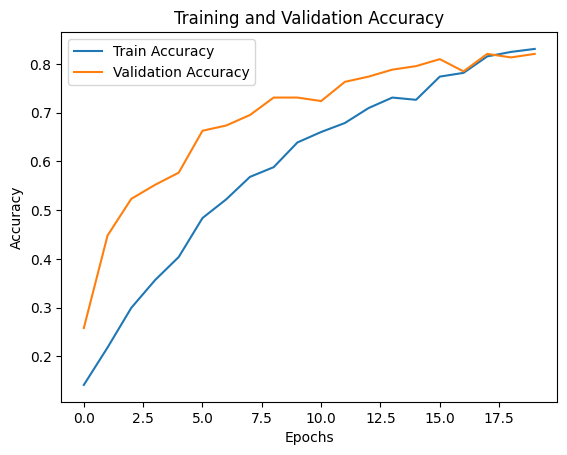

In [8]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()